**Tropical Cyclone Freddy**


**How did Pangu-AI-forecast perform on predicting Freddy using ERA5-data as a comparison?**
- we have Pangu data initialized: 14.02, 19.02, 23.02

**TO DO**
- Neue Variablen und berechnungen in anderem file und abspeichern und hier nur laden
- out_file = "/home/aregger/CRA/data_to_plot.nc"  # change it to your directory
- data_to_plot.to_netcdf(out_file)

**Import libraries**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
from datetime import datetime
import sys
import warnings
from glob import glob
import netCDF4 as nc
import h5netcdf
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.dates import DateFormatter, HourLocator
import datetime as dt
import matplotlib.dates as mdates

**Load the data**

In [2]:
## ERA5
era =  xr.open_dataset('../data/data_new/ERA_data_TC_Freddy2.nc')

## Pangu in one dataset
all_files=sorted(glob('../data/data_new/data_pangu/TC_FREDD*'))
datasets = []
for file in all_files:
    datasets.append(xr.open_dataset(file))
pangu = xr.concat(datasets, dim='time')  # Assuming 'time' is the dimension along which you want to concatenate


C:\Users\tinos\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


**Calculate winds speed at 850/500hPa level and winds speed at SURFACE level**

In [3]:
# era
era = era.assign(wind_speed = lambda era: (era.u**2 + era.v**2)**0.5)
era['wind_speed'].attrs['GRIB_name'] = 'Wind speed'
# for pangu
pangu = pangu.assign(wind_speed = lambda pangu: (pangu.u**2 + pangu.v**2)**0.5)
pangu['wind_speed'].attrs['GRIB_name'] = 'Wind speed'
pangu['msl'].attrs['GRIB_name'] = 'Mean sea level pressure'

# era SURFACE level
era = era.assign(wind_speed_sfc = lambda era: (era.u10**2 + era.v10**2)**0.5)
era['wind_speed_sfc'].attrs['GRIB_name'] = 'Surface wind speed'
# pangu SURFACE level
pangu = pangu.assign(wind_speed_sfc = lambda pangu: (pangu.u10**2 + pangu.v10**2)**0.5)
pangu['wind_speed_sfc'].attrs['GRIB_name'] = 'Surface wind speed'

**Crop the data to lat 10 - 70**

In [4]:
era_cropped = era.where((era.lon >= 25) & (era.lon <= 65), drop=True)
pangu_cropped = pangu.where((pangu.longitude >= 25) & (pangu.longitude <= 65), drop=True)

**Convert Pa to hPa**

In [5]:
era_cropped['msl'] = era_cropped['msl'] / 100
pangu_cropped['msl'] = pangu_cropped['msl'] / 100
pangu_cropped['msl'].attrs['GRIB_name'] = 'Mean sea level pressure'

**Load plotting functions**

In [6]:
%run ../functions/plot_functions.ipynb

**Our Objectives:**
- compare the general storm behavior using 500hPa wind and Mean sea level pressure
- compare the storm severity/danger 500 hPa q (potential rain indicator) and surface winds

In [7]:
# Ranges of variables for discrete legends
u_levels = np.arange(0,27,3)
msl_levels = np.arange(980,1020,5)
q_levels = np.arange(0,0.008,0.0004)
tp_levels = np.arange(0,0.015,0.003)
u_levels_contour = np.linspace(0,30,9)


q_diff_levels = np.arange(-0.004, 0.004001, 0.001)
q_diff_levels = q_diff_levels[q_diff_levels != 0]
msl_diff_levels = np.arange(-20,20,5)

# Color schemes
colors_q = ['lightcyan', 'lightblue', 'lightskyblue', 'deepskyblue', 'dodgerblue', 'royalblue',"blue", 'mediumblue']
q_cmap = colors.LinearSegmentedColormap.from_list('colors_q', colors_q, N=8)

colors_wind_speeds = ['white', 'lightcyan','lightblue', 'gold', 'orange', 'orangered', 'red', 'firebrick']
wind_speed_cmap = colors.LinearSegmentedColormap.from_list('wind_speed_cmap', colors_wind_speeds, N=8) #color map


colors_bwr = ['#000033', '#87CEEB', '#0000FF', '#FFD700', '#FFA500', '#FF4500', '#FF0000', '#8B0000']
bwr_cmap = colors.LinearSegmentedColormap.from_list('differences', colors_bwr, N=8) #color map

## **Plots**

## **1. Wind (500 hPa) + msl Pressure**

In [73]:
pangu_cropped.wind_speed_sfc.sel(time=pangu_cropped.time[1], step=pangu_cropped.step[8]).max()

<xarray.DataArray 'wind_speed_sfc' ()>
array(19.40610123)
Coordinates:
    step               timedelta64[ns] 2 days 06:00:00
    valid_time         datetime64[ns] 2023-02-21T18:00:00
    time               datetime64[ns] 2023-02-19T12:00:00
    meanSea            float64 0.0
    heightAboveGround  float64 10.0

In [68]:
era_cropped.wind_speed_sfc.sel(time="2023-02-21T18:00:00.000000000").max()

<xarray.DataArray 'wind_speed_sfc' ()>
array(26.56214142)
Coordinates:
    time     datetime64[ns] 2023-02-21T18:00:00

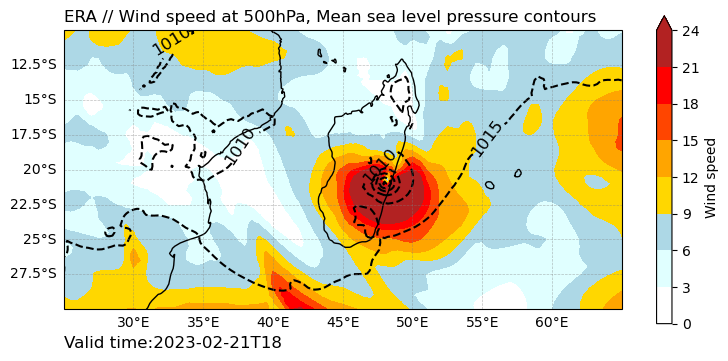

In [8]:
# plots ERA  wind (500hPa) + msl
u_levels_contour = np.linspace(0,30,9)
era_contourfPA_contour(data = era_cropped,
                       contourf_var = era_cropped.wind_speed,
                       contourf_var_inwords = "Wind speed",
                       contour_var = era_cropped.msl,
                       contour_var_inwords = "Mean sea level pressure",
                       step_time = "2023-02-21T18:00:00.000000000",
                       pressure = 500,
                       contourf_lvl = u_levels,
                       contour_lvl = msl_levels,
                       legend_colormap = wind_speed_cmap)

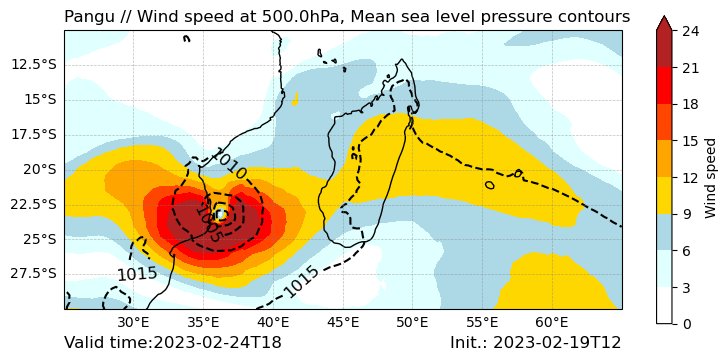

(None,)

In [23]:
# plot pangu_2302  wind (500hPa) + msl
u_levels_contour = np.linspace(0,30,9)
pangu_contourfPA_contour(data = pangu_cropped,
                              contourf_var = pangu_cropped.wind_speed,
                              contour_var = pangu_cropped.msl,
                              ttime = 1,
                              step_time = 20,
                              pressure = 1,
                              contourf_lvl = u_levels,
                              contour_lvl = msl_levels,
                              legend_colormap = wind_speed_cmap,
                             ),




## **2. q (500 hPa) + Surface winds**

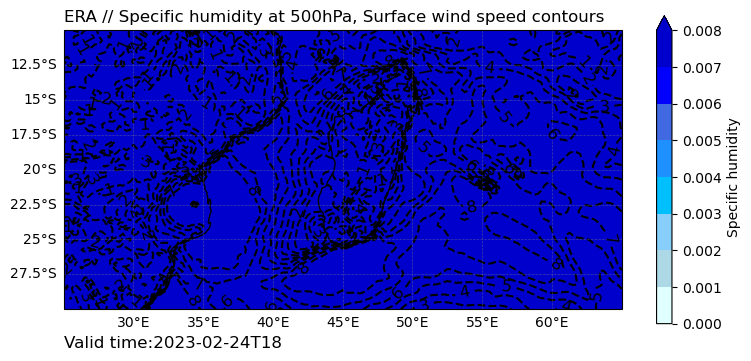

In [107]:
# plots ERA  q and surface winds
q_levels = np.linspace(0,0.008,9)
colors_q = ['lightcyan', 'lightblue', 'lightskyblue', 'deepskyblue', 'dodgerblue', 'royalblue',"blue", 'mediumblue']
q_cmap = colors.LinearSegmentedColormap.from_list('colors_q', colors_q, N=8)

era_contourfPA_contour(data=era_cropped,
                       contourf_var=era_cropped.q,
                       contourf_var_inwords="Specific humidity",
                       contour_var=era_cropped.wind_speed_sfc,
                       contour_var_inwords="Surface wind speed",
                       step_time = "2023-02-24T18:00:00.000000000",
                       pressure = 500,
                       contourf_lvl = q_levels,
                       contour_lvl= u_levels_contour,
                       legend_colormap= q_cmap,
                      )

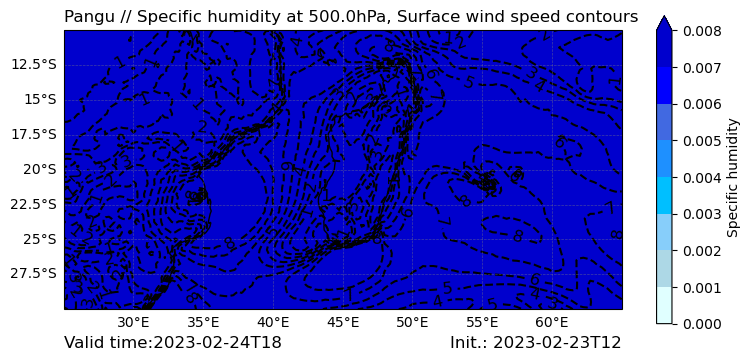

In [106]:
# plot pangu_2302  q and surface winds
q_levels = np.linspace(0,0.008,9)
colors_q = ['lightcyan', 'lightblue', 'lightskyblue', 'deepskyblue', 'dodgerblue', 'royalblue',"blue", 'mediumblue']
q_cmap = colors.LinearSegmentedColormap.from_list('colors_q', colors_q, N=8)

pangu_contourfPA_contour(data = pangu_cropped,
                              contourf_var = pangu_cropped.q,
                              contour_var = pangu_cropped.wind_speed_sfc,
                              ttime = 2,
                              step_time = 4,
                              pressure = 1,
                              contourf_lvl = q_levels,
                              contour_lvl = u_levels_contour,
                              legend_colormap = q_cmap,
                             )

# Plots of surface wind speed and specific humidity

In [8]:
pangu_cropped = pangu_cropped.assign(q=pangu_cropped.q * 1000)

In [9]:
pangu_cropped['q'].attrs['GRIB_name'] = 'Specific humidity'

In [10]:
era_cropped = era_cropped.assign(q = era_cropped.q * 1000)

In [ ]:
%run ../functions/plot_functions.ipynb

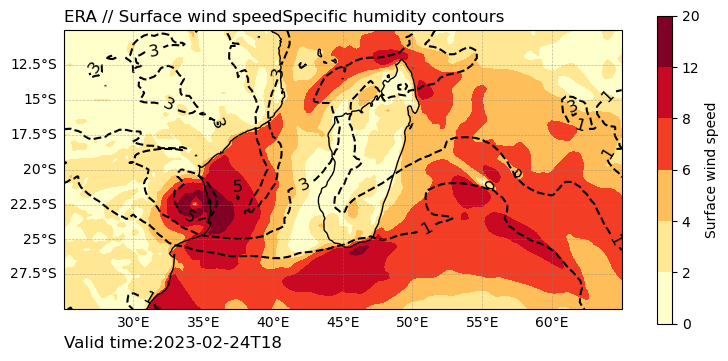

In [21]:
u_levels_contour = np.array([0,2,4,6,8,12,20])
q_levels = np.array([0,1,3,5])

# Original RdPu colormap
rdpu_cmap = plt.get_cmap('YlOrRd')
colors_custom = rdpu_cmap(np.linspace(0, 1, 7))
new_cmap = LinearSegmentedColormap.from_list('custom_RdPu', colors_custom, N=7)


era_contourf_contourPA_test(data=era_cropped,
                       contourf_var=era_cropped.wind_speed_sfc,
                       contourf_var_inwords="Surface wind speed",
                       contour_var=era_cropped.q,
                       contour_var_inwords="Specific humidity",
                       step_time = "2023-02-24T18:00:00.000000000",
                       pressure = 500,
                       contourf_lvl = u_levels_contour,
                       contour_lvl= q_levels,
                       legend_colormap= new_cmap,
                      )

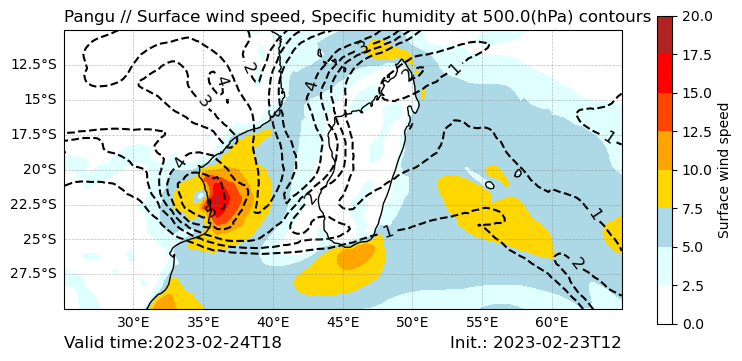

In [112]:
# plot pangu_2302  q and surface winds
q_levels = np.linspace(0,8,9)
u_levels_contour = np.linspace(0,20,9)
#colors_q = ['lightcyan', 'lightblue', 'lightskyblue', 'deepskyblue', 'dodgerblue', 'royalblue',"blue", 'mediumblue']
#q_cmap = colors.LinearSegmentedColormap.from_list('colors_q', colors_q, N=8)

pangu_contourf_contourPA_test(data = pangu_cropped,
                              contourf_var = pangu_cropped.wind_speed_sfc,
                              contour_var = pangu_cropped.q,
                              ttime = 2,
                              pressure=1,
                              step_time = 4,
                              contourf_lvl = u_levels_contour,
                              contour_lvl = q_levels,
                              legend_colormap = wind_speed_cmap,
                             )

## **Differenzplots:**

**The Plan for difference plots**

1. extract the pangu file with the right initialisation and right time step
2. extract the era file with the right time and date 
3. create a substraction xarray with all variables of that time
4. plot the variables (differences) using the plot functions

In [8]:
# extract the pangu file with the right initialisation and right time step

# 21.02 18:00; init 19.02; bad init 14.02
pangu_2102_1800 = pangu_cropped.sel(step = pangu_cropped.step[8],
                                    time = "2023-02-19T12:00:00.000000000"
                                     )
pangu_2102_1800_bad = pangu_cropped.sel(step = pangu_cropped.step[28],
                                      time = "2023-02-14T12:00:00.000000000"
                                     )

# 24.02 18:00; init 23.02; bad init 19.02
pangu_2402_1800 = pangu_cropped.sel(step = pangu_cropped.step[4],
                                    time = "2023-02-23T12:00:00.000000000"
                                     )
pangu_2402_1800_bad = pangu_cropped.sel(step = pangu_cropped.step[20],
                                      time = "2023-02-19T12:00:00.000000000"
                                     )

In [9]:
# extract the era file with the right time and date
# 21.02 18:00
era_2102_1800 = era_cropped.sel(time = "2023-02-21T18:00:00.000000000")

# 24.02 18:00
era_2402_1800 = era_cropped.sel(time = "2023-02-24T18:00:00.000000000")


In [10]:
# for this we need matching coordinates
# lets rename era because we have less datasets there
era_2102_1800 = era_2102_1800.rename({"lat":"latitude", "lon":"longitude", "level":"isobaricInhPa"})
era_2402_1800 = era_2402_1800.rename({"lat":"latitude", "lon":"longitude", "level":"isobaricInhPa"})


In [11]:
# create a substraction xarray with all variables of that time

diff_2102 = era_2102_1800 - pangu_2102_1800
diff_2102_bad = era_2102_1800 - pangu_2102_1800_bad

diff_2402 = era_2402_1800 - pangu_2402_1800
diff_2402_bad = era_2402_1800 - pangu_2402_1800_bad


In [12]:
diff_2102.wind_speed.sel(isobaricInhPa = 500).quantile(q=[0.025, 0.975])

<xarray.DataArray 'wind_speed' (quantile: 2)>
array([-4.49544334,  4.11900377])
Coordinates:
  * quantile  (quantile) float64 0.025 0.975

In [117]:
diff_2102.wind_speed_sfc.min()

<xarray.DataArray 'wind_speed_sfc' ()>
array(-6.44010735)
Coordinates:
    step               timedelta64[ns] 2 days 06:00:00
    valid_time         datetime64[ns] 2023-02-21T18:00:00
    meanSea            float64 0.0
    heightAboveGround  float64 10.0

<xarray.DataArray 'wind_speed_sfc' ()>
array(-6.44010735)
Coordinates:
    step               timedelta64[ns] 2 days 06:00:00
    valid_time         datetime64[ns] 2023-02-21T18:00:00
    meanSea            float64 0.0
    heightAboveGround  float64 10.0

In [120]:
diff_2102

<xarray.Dataset>
Dimensions:            (longitude: 161, latitude: 81, isobaricInhPa: 2)
Coordinates:
  * longitude          (longitude) float32 25.0 25.25 25.5 ... 64.5 64.75 65.0
  * latitude           (latitude) float64 -30.0 -29.75 -29.5 ... -10.25 -10.0
  * isobaricInhPa      (isobaricInhPa) int32 850 500
    step               timedelta64[ns] 2 days 06:00:00
    valid_time         datetime64[ns] 2023-02-21T18:00:00
    meanSea            float64 0.0
    heightAboveGround  float64 10.0
Data variables:
    u10                (latitude, longitude) float32 0.124 -0.4454 ... -0.8624
    v10                (latitude, longitude) float32 0.0107 0.6585 ... 1.411
    msl                (latitude, longitude) float32 -0.2042 -0.2248 ... 0.1053
    u                  (isobaricInhPa, latitude, longitude) float32 -0.9585 ....
    v                  (isobaricInhPa, latitude, longitude) float32 -0.5583 ....
    z                  (isobaricInhPa, latitude, longitude) float32 -10.56 .....
    q                  (isobaricInhPa, latitude, longitude) float32 -0.000776...
    wind_speed         (isobaricInhPa, latitude, longitude) float32 -1.109 .....
    wind_speed_sfc     (latitude, longitude) float32 0.1175 0.02714 ... 1.641

In [151]:
diff_2102.wind_speed_sfc.sel(latitude = slice(-25, -17.5), longitude = slice(45,50)).quantile(q=[0.05,0.95])

<xarray.DataArray 'wind_speed_sfc' (quantile: 2)>
array([-4.84237552,  8.45122623])
Coordinates:
  * quantile  (quantile) float64 0.05 0.95

(array([ 18.,  34.,  30.,  29.,  42., 130., 129.,  65.,  42.,  40.,  25.,
         16.,  17.,  11.,   8.,   3.,   2.,   5.,   2.,   3.]),
 array([-6.44010735, -5.29815292, -4.1561985 , -3.01424384, -1.8722893 ,
        -0.73033476,  0.41161975,  1.55357432,  2.69552875,  3.83748341,
         4.97943783,  6.12139225,  7.26334667,  8.40530109,  9.54725552,
        10.68921089, 11.83116531, 12.97311974, 14.11507416, 15.25702858,
        16.398983  ]),
 <BarContainer object of 20 artists>)

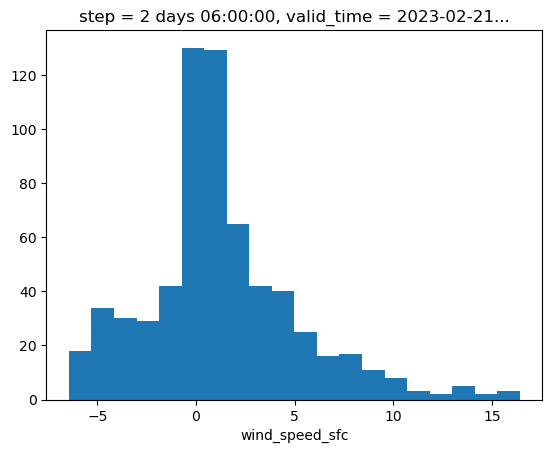

In [145]:
diff_2102.wind_speed_sfc.sel(latitude = slice(-25, -17.5), longitude = slice(45,50)).plot.hist(bins=20)

## Wind speed + msl

C:\Users\tinos\AppData\Local\Temp\ipykernel_9436\1167076345.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bwr_cmap = plt.cm.get_cmap('bwr', 7)


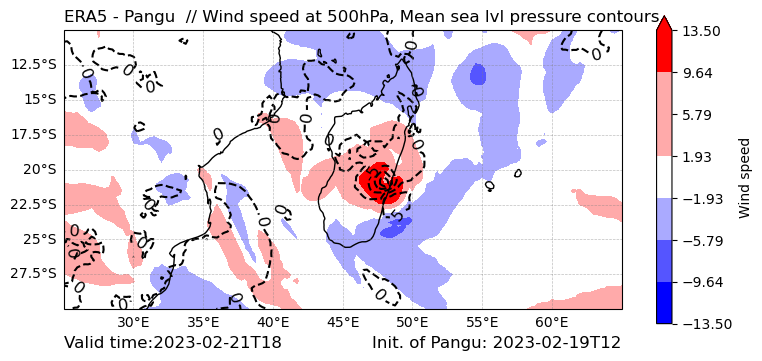

In [237]:
u_diff_levels = np.linspace(-13.5,13.5,8)
u_diff_levels = u_diff_levels[u_diff_levels != 0]

bwr_cmap = plt.cm.get_cmap('bwr', 7)

diff_contourfPA_contour(data = diff_2102, #the whole dataset
                        contourf_var = diff_2102.wind_speed, #base variable
                        contour_var = diff_2102.msl,  #overlaying variable !only surface processes
                        init_pangu = "2023-02-19T12",    #initialisation of pangu as a string like "2023-02-23T12"
                        pressure = 1,     #pressure lvl (500 == 1/850 == 0)
                        contourf_lvl = u_diff_levels, #base variable range 
                        contour_lvl = msl_diff_levels,  #overlaying variable range
                        legend_colormap = bwr_cmap, #color scheme as a map
                        legend_title = "Wind speed",    #variable name for legend
                        contour_var_name = "Mean sea lvl pressure" #name of the second variable for plot text
                            )

## **Differenzplots: q + surface winds**

C:\Users\tinos\AppData\Local\Temp\ipykernel_9436\1443579040.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bwr_cmap = plt.cm.get_cmap('bwr', 7)


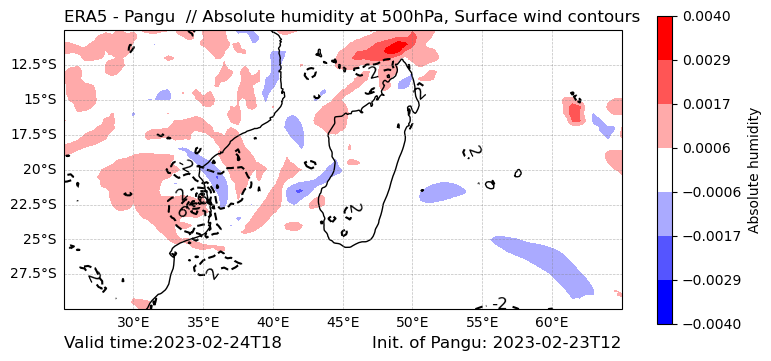

In [246]:
bwr_cmap = plt.cm.get_cmap('bwr', 7)

q_diff_levels = np.linspace(-0.004, 0.004, 8)
q_diff_levels = q_diff_levels[q_diff_levels != 0]
q_diff_levels = np.round(q_diff_levels, 4)

diff_contourfPA_contour(data = diff_2402, #the whole dataset
                        contourf_var = diff_2402.q, #base variable
                        contour_var = diff_2402.wind_speed_sfc,  #overlaying variable !only surface processes
                        init_pangu = "2023-02-23T12",    #initialisation of pangu as a string like "2023-02-23T12"
                        pressure = 1,     #pressure lvl (500 == 1/850 == 0)
                        contourf_lvl = q_diff_levels, #base variable range 
                        contour_lvl = u_diff_levels,  #overlaying variable range
                        legend_colormap = bwr_cmap, #color scheme as a map
                        legend_title = "Absolute humidity",    #variable name for legend
                        contour_var_name = "Surface wind" #name of the second variable for plot text
                            )

## Trackplots

**Plan for Trackplots**
1. extract all the lowest pressure (msl) coordinates from ERA when the storm enters the plotfield
2. extract all the lowest pressure (msl) coordinates from pangu from the appropriate init
4. make ERA track plot
5. make good pangu plot with numbers next to crosses in hours since init time




In [13]:
# extract all the lowest pressure (msl) coordinates from ERA when the storm enters the plotfield
# from "2023-02-19T12:00:00.000000000" to "2023-03-13T12:00:00.000000000"

date_sequence = pd.date_range(start="2023-02-19T18:00:00.000000000", end="2023-03-13T12:00:00.000000000", freq="6H")
date_strings = [date.strftime("%Y-%m-%dT%H:%M:%S.%f") for date in date_sequence]

lats = []
lons = []


for i in list(range(len(date_strings))):
    
    era_time = era_cropped.msl.sel(time = date_strings[i])
    
    min_value = era_time.min()
    
    # Find the positions where the array equals the desired value
    positions = (era_time == min_value).values.nonzero()
    
    # Extract the latitude and longitude coordinates corresponding to those positions
    lat = era_time.coords['lat'].values[positions[0][0]]
    lon = era_time.coords['lon'].values[positions[1][0]]
    
    lats.append(lat)
    lons.append(lon)
    


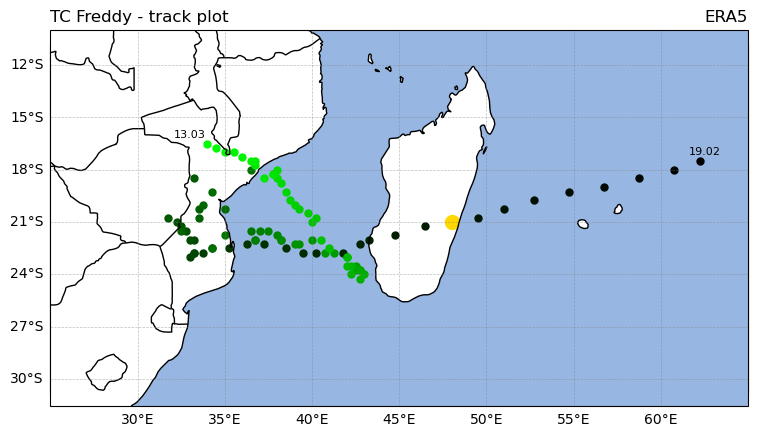

In [14]:
# make ERA track plot

# Get the extent of your dataset
extent = [era_cropped.lon.min(), era_cropped.lon.max(), era_cropped.lat.min(), era_cropped.lat.max()]

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Define map projections
map_projection = ccrs.PlateCarree()
ax = plt.axes(projection=map_projection)


# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Specify the tick labels
gl.top_labels = False  # Disable labels on top
gl.right_labels = False  # Disable labels on right side
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Set the extent of the map
ax.set_extent(extent)

# Add coastlines and oceans
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)


# Define number of levels for the color gradient
num_levels = len(lats)

# Plot specific coordinates with a custom color gradient
for lon, lat, i in zip(lons, lats, range(num_levels)):
    # Create a custom colormap from black to red for each dot
    colors = [(0, 0, 0), (0, 1, 0)]  # Black to red
    custom_cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=num_levels)
    ax.scatter(lon, lat, marker='.', color=custom_cmap(i), s=100)

# Plot Points of future Analysis
ax.scatter(lons[8], lats[8], marker='.', color="gold", s=400)
#ax.scatter(lons[20], lats[20], marker='.', color="gold", s=400)

# add init times
ax.text(62.5,-17, "19.02", color='black', fontsize=8, ha='center', va='center',  transform=ccrs.PlateCarree())
ax.text(33,-16, "13.03", color='black', fontsize=8, ha='center', va='center',  transform=ccrs.PlateCarree())

# title variable description
ax.set_title("TC Freddy - track plot", loc ="left");
ax.set_title("ERA5", loc='right');
    
# save file in folder: plots    
plt.savefig("../plots/ERA_trackplot.png", dpi=300, bbox_inches='tight')
    
# Show the plot
plt.show()

In [13]:
# extract all the lowest pressure (msl) coordinates from pangu from the appropriate init
# from "2023-02-19T18:00:00.000000000" to "2023-03-13T12:00:00.000000000"

# pangu init 19.02 "2023-02-19T18:00:00.000000000" - "2023-02-23T12:00:00.000000000"
lats_1 = []
lons_1 = []

lats_2 = []
lons_2 = []


for i in list(range(16)):
    
    pangu_time = pangu_cropped.msl.sel( step = pangu_cropped.step[i], time = '2023-02-19T12:00:00.000000000',
                                      latitude = slice(-12,-27))
    
    min_value = pangu_time.min()
    
    # Find the positions where the array equals the desired value
    positions = (pangu_time == min_value).values.nonzero()
    
    # Extract the latitude and longitude coordinates corresponding to those positions
    lat = pangu_time.coords['latitude'].values[positions[0][0]]
    lon = pangu_time.coords['longitude'].values[positions[1][0]]
    
    lats_1.append(lat)
    lons_1.append(lon)
    
# pangu init 23.02 "2023-02-23T18:00:00.000000000" - "2023-03-13T12:00:00.000000000"
for i in list(range(13)):
    
    pangu_time = pangu_cropped.msl.sel( step = pangu_cropped.step[i], time = '2023-02-23T12:00:00.000000000')
    
    min_value = pangu_time.min()
    
    # Find the positions where the array equals the desired value
    positions = (pangu_time == min_value).values.nonzero()
    
    # Extract the latitude and longitude coordinates corresponding to those positions
    lat = pangu_time.coords['latitude'].values[positions[0][0]]
    lon = pangu_time.coords['longitude'].values[positions[1][0]]
    
    lats_2.append(lat)
    lons_2.append(lon)

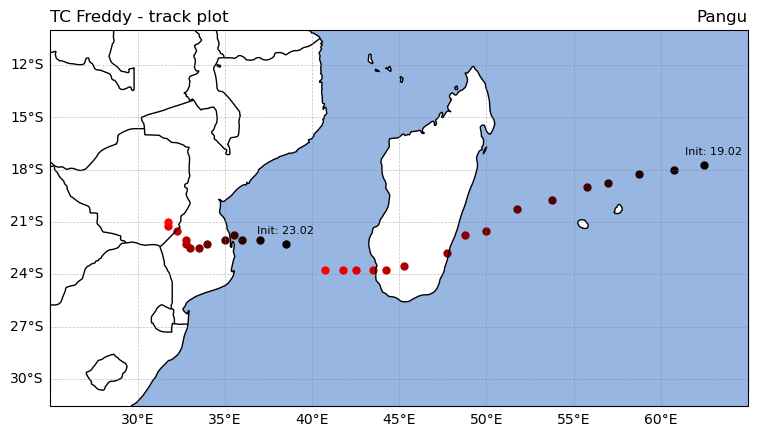

In [14]:
# make Pangu track plot

# Get the extent of your dataset
extent = [era_cropped.lon.min(), era_cropped.lon.max(), era_cropped.lat.min(), era_cropped.lat.max()]

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Define map projections
map_projection = ccrs.PlateCarree()
ax = plt.axes(projection=map_projection)


# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Specify the tick labels
gl.top_labels = False  # Disable labels on top
gl.right_labels = False  # Disable labels on right side
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Set the extent of the map
ax.set_extent(extent)

# Add coastlines and oceans
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)


# Define number of levels for the color gradient
num_levels = len(lats_1)

# Plot specific coordinates with a custom color gradient
for lon, lat, i in zip(lons_1, lats_1, range(num_levels)):
    # Create a custom colormap from black to red for each dot
    colors = [(0, 0, 0), (1, 0, 0)]  # Black to red
    custom_cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=num_levels)
    ax.scatter(lon, lat, marker='.', color=custom_cmap(i), s=100)

# Define number of levels for the color gradient
num_levels = len(lats_2)

# Plot specific coordinates with a custom color gradient
for lon, lat, i in zip(lons_2, lats_2, range(num_levels)):
    # Create a custom colormap from black to red for each dot
    colors = [(0, 0, 0), (1, 0, 0)]  # Black to red
    custom_cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=num_levels)
    ax.scatter(lon, lat, marker='.', color=custom_cmap(i), s=100)
    
# title variable description
ax.set_title("TC Freddy - track plot", loc ="left");
ax.set_title("Pangu", loc='right');

# add init times
ax.text(63,-17, "Init: 19.02", color='black', fontsize=8, ha='center', va='center',  transform=ccrs.PlateCarree())
ax.text(38.5,-21.5, "Init: 23.02", color='black', fontsize=8, ha='center', va='center',  transform=ccrs.PlateCarree())
    
    
# save file in folder: plots    
plt.savefig("../plots/Pangu_trackplot.png", dpi=300, bbox_inches='tight')
    
# Show the plot
plt.show()

## Spatial distance of Pangu and ERA

In [15]:
# calculate the spatial distance between the ERA low pressure center and pangu low pressure center

# Pangu only data for 29 6-hour intervals
# consequently, crop era to 0:28
lats_cropped = lats[0:29]
lons_cropped = lons[0:29]

# append pangu coordinates
lats_pangu = lats_1.copy()
lons_pangu = lons_1.copy()

for i in lats_2:
    lats_pangu.append(i)
    
for i in lons_2:
    lons_pangu.append(i)

In [16]:
distances = []

for (lat_cropped, lon_cropped, lat_pangu, lon_pangu) in zip(lats_cropped, lons_cropped, lats_pangu, lons_pangu):
    result = haversine(lat_cropped, lon_cropped, lat_pangu, lon_pangu)
    distances.append(result)


In [26]:
from sklearn.linear_model import LinearRegression

In [43]:
x_1 = np.array(range(len(distances[:16]))).reshape((-1, 1))
y_1 = np.array(distances[:16])

x_2 = np.array(range(len(distances[16:]))).reshape((-1, 1))
y_2 = np.array(distances[16:])

In [44]:
model = LinearRegression()
m1 = model.fit(x_1,y_1)
m2 = model.fit(x_2, y_2)

In [46]:
print(f"coefficient of determination: "+ str(m2.score(x_2, y_2)))
print(f"slope: {m2.coef_}")


coefficient of determination: 0.21644925506560087
slope: [3.12822159]


In [49]:
distances[15]-distances[16]

141.5306183686759

In [50]:
len(distances[:16])

16

In [51]:
len(distances[16:])

13

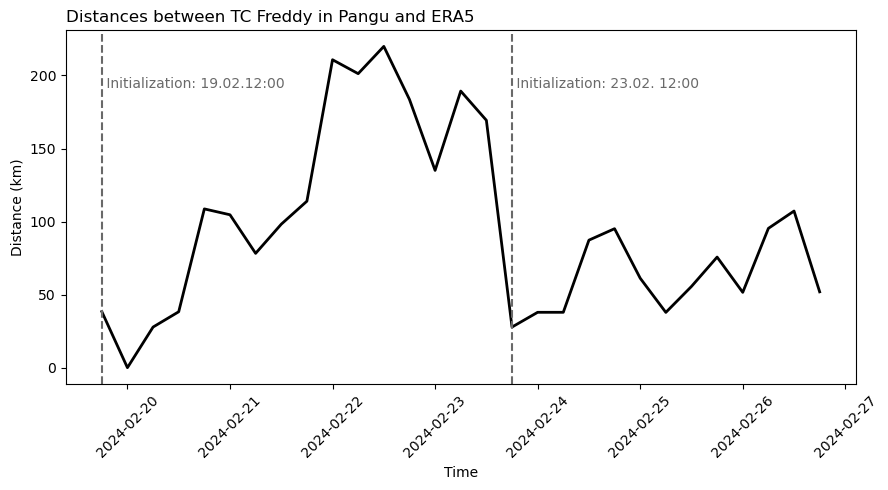

In [17]:
import matplotlib.pyplot as plt
import datetime as dt

# Assuming `distances` contains the calculated distances

# Generate date sequence starting from "2024-02-19 18:00" and incrementing by 6 hours
start_date = dt.datetime(2024, 2, 19, 18, 0)
end_date = dt.datetime(2024, 2, 27, 0, 0)  # Set end date to "2024-02-27 00:00"
date_seq = [start_date + dt.timedelta(hours=6*i) for i in range(len(distances))]


# Set the size of the plot
plt.figure(figsize=(9, 5))

# Plot distances as a line plot
plt.plot(date_seq, distances, "-", color = "black", linewidth =2)

# Add a vertical line at index 15
plt.axvline(x=date_seq[16], color='dimgray', linestyle='--')
plt.axvline(x=date_seq[0], color='dimgray', linestyle='--')

# Add text inside the plot
plt.text(date_seq[0], distances[14], ' Initialization: 19.02.12:00', color='dimgray', fontsize=10, va='bottom', ha='left')
plt.text(date_seq[16], distances[14], ' Initialization: 23.02. 12:00', color='dimgray', fontsize=10, va='bottom', ha='left')
# Format x-axis ticks with date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set ticks on x-axis without labels
#plt.xticks(date_seq)
plt.xticks(rotation=45)

# Remove top and right axes
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Distance (km)')
plt.title('Distances between TC Freddy in Pangu and ERA5', loc = "left")

# save file in folder: plots    
plt.savefig("../plots/Distances_trackplot.png", dpi=300, bbox_inches='tight')


# Show plot
plt.tight_layout()
plt.show()


## MAKE THIS PLOT BUT WITH A COLOR GRADIENT SHOWING THE NEW INITIALIZATION AND IN THE COLOR FROM BLACK TO RED LIKE IN THE TRACK PLOT

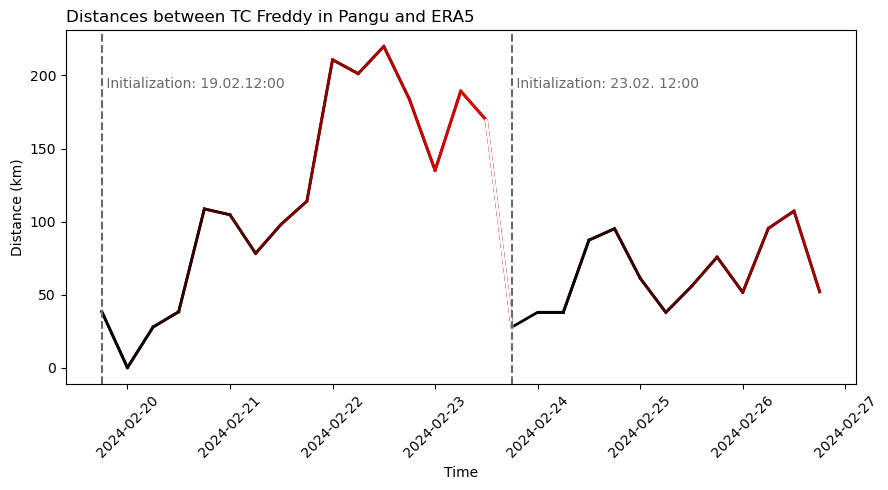

In [50]:
import matplotlib.pyplot as plt
import datetime as dt

# Assuming `distances` contains the calculated distances

# Generate date sequence starting from "2024-02-19 18:00" and incrementing by 6 hours
start_date = dt.datetime(2024, 2, 19, 18, 0)
end_date = dt.datetime(2024, 2, 27, 0, 0)  # Set end date to "2024-02-27 00:00"
date_seq = [start_date + dt.timedelta(hours=6*i) for i in range(len(distances))]


# Set the size of the plot
plt.figure(figsize=(9, 5))

# Plot distances as a line plot
plt.plot(date_seq, distances, "-", color = "black", linewidth =2)


color_scheme = [
    "#000000",  # Black
    "#110000",
    "#220000",
    "#330000",
    "#440000",
    "#550000",
    "#660000",
    "#770000",
    "#880000",
    "#990000",
    "#AA0000",
    "#BB0000",
    "#CC0000",
    "#DD0000",
    "#EE0000",
    "#FF0000",  # Red
    "#FF0000"
]


color_scheme_2 = [
    "#000000",  # Black
    "#110000",
    "#220000",
    "#330000",
    "#440000",
    "#550000",
    "#660000",
    "#770000",
    "#880000",
    "#990000",
    "#AA0000",
    "#BB0000",
    "#CC0000",
    "#FF0000"   # Red
]

    
    
for i in range(len(date_seq[:16])):
    # Plot distances as a line plot
    plt.plot(date_seq[i:i+2], distances[i:i+2], "-", color = color_scheme[i], linewidth =2)
    
for i in range(len(date_seq[16:])):
    # Plot distances as a line plot
    plt.plot(date_seq[17+i:19+i], distances[17+i:19+i], "-", color = color_scheme_2[i], linewidth =2)

# Plot distances as a line plot
plt.plot(date_seq[15:17], distances[15:17], "-", color = "white", linewidth =2)

# Add a vertical line at index 15
plt.axvline(x=date_seq[16], color='dimgray', linestyle='--')
plt.axvline(x=date_seq[0], color='dimgray', linestyle='--')

# Add text inside the plot
plt.text(date_seq[0], distances[14], ' Initialization: 19.02.12:00', color='dimgray', fontsize=10, va='bottom', ha='left')
plt.text(date_seq[16], distances[14], ' Initialization: 23.02. 12:00', color='dimgray', fontsize=10, va='bottom', ha='left')
# Format x-axis ticks with date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set ticks on x-axis without labels
#plt.xticks(date_seq)
plt.xticks(rotation=45)

# Remove top and right axes
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Distance (km)')
plt.title('Distances between TC Freddy in Pangu and ERA5', loc = "left")

# save file in folder: plots    
plt.savefig("../plots/Distances_trackplot.png", dpi=300, bbox_inches='tight')


# Show plot
plt.tight_layout()
plt.show()
